In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Flatten, Conv1D, Convolution1D, \
                         MaxPooling1D, GlobalAveragePooling1D, Reshape, CuDNNLSTM, CuDNNGRU, Concatenate, Input, LSTM, Layer
from keras.layers.wrappers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
from bettertensorboard import TrainValTensorBoard
import os
%config InlineBackend.figure_format = 'retina'

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

# Loading the data

In [6]:
data_dir = '../data/'
dataset_filename = 'energy-dataset.csv'
rna_alphabet = 'A C G T'.split()
rna_size = 50

In [7]:
data = pd.read_csv(data_dir + dataset_filename, header=None)
data.head()

0    1
0  GATTCCCAGAGATGACCCCTCTTCACCGCCAAATTGGCAAGAATTC... -6.6
1  GAGGCAGAAGCAGATGCACCCCCAAATCTCCGACAATTTTGATTCC... -5.2
2  GATGCCCCCGAGAGAATGAGCTCAACACTCCCCATTTTCCAATTCA... -5.4
3  GGATTTCCCACAGCATCTTGAGCAAGATTGCGAAAAGACTCCCCAT... -6.6
4  GCCCATTGACTCAGAACCAGAGATCCCTTGAAGCAATCCCCGGCAA... -6.2

In [8]:
X = np.array([list(i) for i in data[0].values])
X_all = np.array([list(i * rna_size) for i in rna_alphabet])

In [9]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(X_all)
X = one_hot_encoder.transform(X).reshape(-1, rna_size, len(rna_alphabet))
X.shape

(1000000, 50, 4)

In [10]:
y = data[1].values.reshape(-1, 1)
y.shape

(1000000, 1)

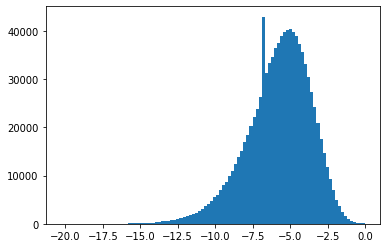

In [11]:
plt.hist(y, bins=100);

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [13]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [14]:
early_stopping = EarlyStopping(monitor='val_r_square', patience=10, verbose=1, mode='auto')

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [15]:
def plot_history(history, metric):
    plt.figure(figsize=(16, 6));
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1);
    plt.plot(history.history[metric]);
    plt.plot(history.history['val_' + metric]);
    plt.title('Model ' + metric);
    plt.ylabel(metric);
    plt.xlabel('Epoch');
    plt.legend(['Train', 'Test'], loc='best');

    # Plot training & validation loss values
    plt.subplot(1, 2, 2);
    plt.plot(history.history['loss']);
    plt.plot(history.history['val_loss']);
    plt.title('Model loss');
    plt.ylabel('Loss');
    plt.xlabel('Epoch');
    plt.legend(['Train', 'Test'], loc='best');

# Training Models

In [16]:
tensorboard = TrainValTensorBoard()

## Fully Connected

In [35]:
def create_fc(input_shape):
    x = Input(shape=input_shape)
    
    flat = Flatten()(x)

    y = Dense(512)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)
    
    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)

    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)
    
    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)

    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)

    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)

    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)

    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.2)(y)
    
    y = Dense(512)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [36]:
fc = create_fc(X_train.shape[1:])
fc.compile(optimizer='nadam', loss=rmse, metrics=[r_square])
fc.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 512)               102912    
_________________________________________________________________
batch_normalization_51 (Batc (None, 512)               2048      
_________________________________________________________________
activation_51 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
___________________________

In [37]:
fc_history = fc.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/20
640000/640000 [==============================] - 189s 296us/step - loss: 4.0481 - r_square: -2.9259 - val_loss: 2.3669 - val_r_square: -0.2360
Epoch 2/20
640000/640000 [==============================] - 184s 288us/step - loss: 2.1276 - r_square: -0.0058 - val_loss: 2.0830 - val_r_square: 0.0431
Epoch 3/20
640000/640000 [==============================] - 181s 283us/step - loss: 2.0664 - r_square: 0.0527 - val_loss: 2.0700 - val_r_square: 0.0552
Epoch 4/20
640000/640000 [==============================] - 179s 279us/step - loss: 2.0555 - r_square: 0.0624 - val_loss: 2.0657 - val_r_square: 0.0591
Epoch 5/20
640000/640000 [==============================] - 174s 272us/step - loss: 2.0455 - r_square: 0.0713 - val_loss: 2.0635 - val_r_square: 0.0610
Epoch 6/20
640000/640000 [==============================] - 179s 280us/step - loss: 2.0361 - r_square: 0.0798 - val_loss: 2.0625 - val_r_square: 0.0621
Epoch 7/20
640000/640000 [=======

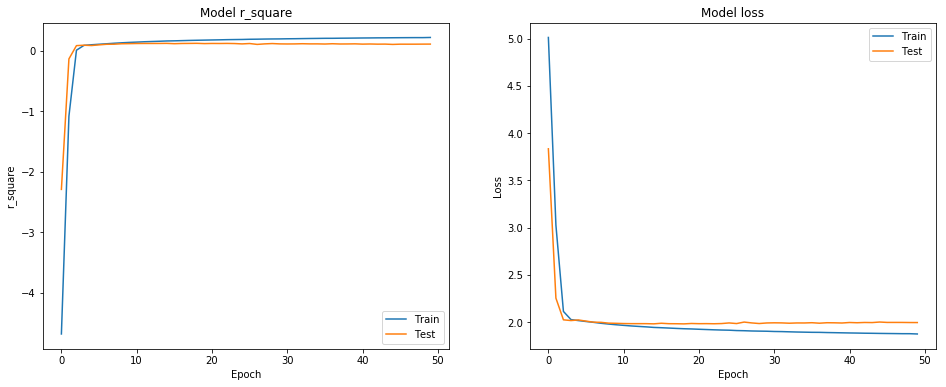

In [ ]:
plot_history(fc_history, 'r_square')
plt.show();

## CNN

In [ ]:
def create_cnn(input_shape):
    """
    a CNN model which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    cnn = Conv1D(filters=64, kernel_size=5)(x)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)

    cnn = Conv1D(filters=64, kernel_size=5)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)

    cnn = Conv1D(filters=64, kernel_size=5)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    cnn = MaxPooling1D(pool_size=4)(cnn)

    flat = Flatten()(cnn)

    y = Dense(64)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [ ]:
cnn = create_cnn(X_train.shape[1:])
cnn.compile(optimizer='adam', loss=rmse, metrics=[r_square])
cnn.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 46, 64)            1344      
_________________________________________________________________
batch_normalization_7 (Batch (None, 46, 64)            256       
_________________________________________________________________
activation_7 (Activation)    (None, 46, 64)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 23, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 19, 64)            20544     
_________________________________________________________________
batch_normalization_8 (Batch (None, 19, 64)            256 

In [ ]:
cnn_history = cnn.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/50
640000/640000 [==============================] - 36s 55us/step - loss: 5.0114 - r_square: -4.6801 - val_loss: 3.8332 - val_r_square: -2.2899
Epoch 2/50
640000/640000 [==============================] - 34s 52us/step - loss: 3.0259 - r_square: -1.0800 - val_loss: 2.2527 - val_r_square: -0.1322
Epoch 3/50
640000/640000 [==============================] - 34s 53us/step - loss: 2.1122 - r_square: 0.0112 - val_loss: 2.0234 - val_r_square: 0.0868
Epoch 4/50
640000/640000 [==============================] - 34s 53us/step - loss: 2.0260 - r_square: 0.0913 - val_loss: 2.0156 - val_r_square: 0.0939
Epoch 5/50
640000/640000 [==============================] - 34s 53us/step - loss: 2.0152 - r_square: 0.1011 - val_loss: 2.0219 - val_r_square: 0.0884
Epoch 6/50
640000/640000 [==============================] - 33s 52us/step - loss: 2.0056 - r_square: 0.1094 - val_loss: 2.0095 - val_r_square: 0.0994
Epoch 7/50
640000/640000 [==================

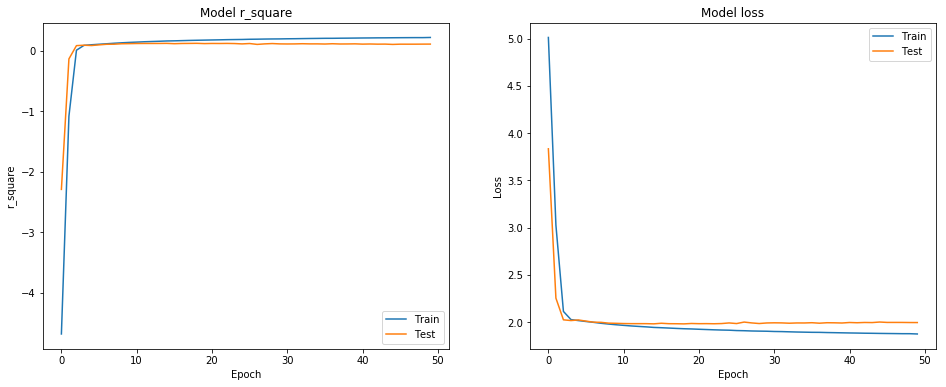

In [ ]:
plot_history(cnn_history, 'r_square')
plt.show();

## RNN

In [ ]:
def create_rnn(input_shape):
    """
    a Bidirectional LSTM model which predicts from the sequence only
    """
    x = Input(shape=input_shape)

    rnn = Bidirectional(CuDNNLSTM(units=64, return_sequences=True))(x)

    rnn = Bidirectional(CuDNNLSTM(units=64, return_sequences=True))(rnn)

    flat = Flatten()(rnn)

    y = Dense(32)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [ ]:
rnn = create_rnn(X_train.shape[1:])
rnn.compile(optimizer='rmsprop', loss=rmse, metrics=[r_square])
rnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50, 4)             0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 50, 64)            9728      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 64)            25088     
_________________________________________________________________
flatten_6 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                102432    
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
activation_16 (Activation)   (None, 32)                0   

In [ ]:
rnn_history = rnn.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/20
640000/640000 [==============================] - 160s 250us/step - loss: 4.9886 - r_square: -4.6508 - val_loss: 3.6038 - val_r_square: -1.8768
Epoch 2/20
640000/640000 [==============================] - 157s 246us/step - loss: 2.9283 - r_square: -0.9635 - val_loss: 2.1240 - val_r_square: 0.0044
Epoch 3/20
640000/640000 [==============================] - 157s 245us/step - loss: 2.0484 - r_square: 0.0678 - val_loss: 2.0175 - val_r_square: 0.1017
Epoch 4/20
640000/640000 [==============================] - 157s 246us/step - loss: 2.0134 - r_square: 0.0999 - val_loss: 2.0124 - val_r_square: 0.1053
Epoch 5/20
640000/640000 [==============================] - 157s 245us/step - loss: 1.9877 - r_square: 0.1224 - val_loss: 1.9689 - val_r_square: 0.1437
Epoch 6/20
640000/640000 [==============================] - 157s 245us/step - loss: 1.9687 - r_square: 0.1392 - val_loss: 1.9847 - val_r_square: 0.1304
Epoch 7/20
640000/640000 [=======

In [ ]:
plot_history(rnn_history, 'r_square')
plt.show();

It will go up to 0.36 of $R^2$.

## Fixed Dilated CNN

In [ ]:
class FixedDilatedCNN(Layer):
    """
    This layer takes a tensor in shape (n_samples, rna_length, 4) and returns a
    tensor in shape (n_samples, rna_length, n_structural_features)

    It uses a kind of dilated CNN with no trainable parameters to extract the
    RNA structural features
    """

    def __init__(self, dilation_start=2, dilation_end=None, n_bulge=2, **kwargs):
        self.dilation_start = dilation_start
        self.dilation_end = dilation_end
        self.n_bulge = n_bulge
        self.n_dilations = None
        super(FixedDilatedCNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dilation_end is None:
            self.dilation_end = int(input_shape[1] / 2 - 1)
        self.n_dilations = self.dilation_end - self.dilation_start
        super(FixedDilatedCNN, self).build(input_shape)

    def dilate(self, x, space, weights):
        weights = np.array(weights).reshape((1, 1, -1))
        x_padded_left = K.temporal_padding(x, (space+1, 0))
        x_padded_right = K.temporal_padding(x, (0, space+1))
        dilation = x_padded_right[:, space+1:, :] * x_padded_left[:, :-(space+1), ::-1]
        dilation = dilation * weights
        return K.sum(dilation, axis=2)
    
    def left_bulge_dilate(self, x, space, weights, bulge_size):
        x_padded_left = K.temporal_padding(x, (space+1+bulge_size, 0))
        x_padded_right = K.temporal_padding(x, (0, space+1))
        dilation = x_padded_right[:, space+1:, :] * x_padded_left[:, :-(space+1+bulge_size), ::-1]
        weights = np.array(weights).reshape((1, 1, -1))
        dilation = dilation * weights
        return K.sum(dilation, axis=2)
    
    def right_bulge_dilate(self, x, space, weights, bulge_size):
        x_padded_left = K.temporal_padding(x, (space+1, 0))
        x_padded_right = K.temporal_padding(x, (0, space+1+bulge_size))
        dilation = x_padded_right[:, space+1+bulge_size:, :] * x_padded_left[:, :-(space+1), ::-1]
        weights = np.array(weights).reshape((1, 1, -1))
        dilation = dilation * weights
        return K.sum(dilation, axis=2)
        
        
    def call(self, x):
        result = []

        for s in range(self.dilation_start, self.dilation_end):
            AU_CG = dilate(x, s, weights=[2, 3, 3, 2])
            GU = dilate(x[:, :, 2:], s, weights=[2, 2])
            result.append(AU_CG + GU)

            for d in range(1, self.n_bulge+1):
                # left bulges
                dilation = self.left_bulge_dilate(x, s, [2, 3, 3, 2], d)
                result.append(dilation)
                
            for d in range(1, self.n_bulge+1):
                # right bulges
                dilation = self.right_bulge_dilate(x, s, [2, 3, 3, 2], d)
                result.append(dilation)
 
        result = K.stack(result)
        result = K.permute_dimensions(result, (1, 2, 0))
        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], self.n_dilations * (self.n_bulge * 2 + 1))

## Fixed Dilated CNN + CNN

In [19]:
def create_fixed_dilated_cnn(input_shape):
    x = Input(shape=input_shape)
    x_dilated = FixedDilatedCNN(dilation_start=2)(x)

    cnn1 = Conv1D(filters=64, kernel_size=16, padding='same')(x)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = Conv1D(filters=64, kernel_size=10, padding='same')(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=2)(cnn1)

    cnn1 = Conv1D(filters=64, kernel_size=5)(cnn1)
    cnn1 = BatchNormalization()(cnn1)
    cnn1 = Activation('relu')(cnn1)
    cnn1 = MaxPooling1D(pool_size=4)(cnn1)

    cnn2 = Conv1D(filters=64, kernel_size=12)(x_dilated)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    cnn2 = Conv1D(filters=64, kernel_size=7)(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    cnn2 = Conv1D(filters=64, kernel_size=5)(cnn2)
    cnn2 = BatchNormalization()(cnn2)
    cnn2 = Activation('relu')(cnn2)
    cnn2 = MaxPooling1D(pool_size=2)(cnn2)

    flat = Concatenate()([Flatten()(cnn1), Flatten()(cnn2)])

    y = Dense(64)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [20]:
fixed_dilated_cnn = create_fixed_dilated_cnn(X_train.shape[1:])
fixed_dilated_cnn.compile(optimizer='adam', loss=rmse, metrics=[r_square])
fixed_dilated_cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 4)        0                                            
__________________________________________________________________________________________________
fixed_dilated_cnn_3 (FixedDilat (None, 50, 110)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 50, 64)       4160        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 39, 64)       84544       fixed_dilated_cnn_3[0][0]        
__________________________________________________________________________________________________
batch_norm

In [21]:
fdcnn_history = fixed_dilated_cnn.fit(X_train, y_train, batch_size=256, epochs=100, validation_split=.2)

Train on 640000 samples, validate on 160000 samples
Epoch 1/100
640000/640000 [==============================] - 91s 142us/step - loss: 4.9888 - r_square: -4.6325 - val_loss: 3.9523 - val_r_square: -2.4996
Epoch 2/100
640000/640000 [==============================] - 86s 135us/step - loss: 2.8457 - r_square: -0.8592 - val_loss: 2.0707 - val_r_square: 0.0401
Epoch 3/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.7191 - r_square: 0.3422 - val_loss: 1.5642 - val_r_square: 0.4522
Epoch 4/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.5620 - r_square: 0.4582 - val_loss: 1.5153 - val_r_square: 0.4854
Epoch 5/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.5080 - r_square: 0.4949 - val_loss: 1.4882 - val_r_square: 0.5039
Epoch 6/100
640000/640000 [==============================] - 86s 135us/step - loss: 1.4693 - r_square: 0.5202 - val_loss: 1.4424 - val_r_square: 0.5338
Epoch 7/100
640000/640000 [======

In [22]:
plot_history(fdcnn_history, 'r_square')
plt.show();

## Fixed Dilated CNN + RNN

In [22]:
def create_fixed_dilated_cnn_rnn(input_shape):
    x = Input(shape=input_shape)
    x_dilated = FixedDilatedCNN(dilation_start=2)(x)

    rnn1 = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x)

    rnn1 = Bidirectional(CuDNNLSTM(units=16, return_sequences=True))(rnn1)
    
    rnn2 = Bidirectional(CuDNNLSTM(units=32, return_sequences=True))(x_dilated)
    
    rnn2 = Bidirectional(CuDNNLSTM(units=16, return_sequences=True))(rnn2)

    flat = Concatenate()([Flatten()(rnn1), Flatten()(rnn2)])

    y = Dense(32)(flat)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(32)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(.5)(y)

    y = Dense(1)(y)
    y = BatchNormalization()(y)
    y = Activation('linear')(y)

    return Model(inputs=x, outputs=y)

In [23]:
fixed_dilated_cnn_rnn = create_fixed_dilated_cnn_rnn(X_train.shape[1:])
fixed_dilated_cnn_rnn.compile(optimizer='rmsprop', loss=rmse, metrics=[r_square])
fixed_dilated_cnn_rnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50, 4)        0                                            
__________________________________________________________________________________________________
fixed_dilated_cnn_2 (FixedDilat (None, 50, 110)      0           input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 50, 64)       9728        input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 50, 64)       36864       fixed_dilated_cnn_2[0][0]        
__________________________________________________________________________________________________
bidirectio

In [28]:
fdcnn_rnn_history = fixed_dilated_cnn_rnn.fit(X_train, y_train, batch_size=256, epochs=200, validation_split=.2,
                                             callbacks=[tensorboard], initial_epoch=68)

Train on 640000 samples, validate on 160000 samples
Epoch 69/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.2256 - r_square: 0.6659 - val_loss: 1.2477 - val_r_square: 0.6537
Epoch 70/200
640000/640000 [==============================] - 114s 179us/step - loss: 1.2236 - r_square: 0.6669 - val_loss: 1.2219 - val_r_square: 0.6673
Epoch 71/200
351232/640000 [===============>..............] - ETA: 46s - loss: 1.2176 - r_square: 0.6705

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 181us/step - loss: 1.2211 - r_square: 0.6683 - val_loss: 1.2708 - val_r_square: 0.6406
Epoch 76/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.2209 - r_square: 0.6684 - val_loss: 1.2368 - val_r_square: 0.6593
Epoch 77/200
158464/640000 [======>.......................] - ETA: 1:19 - loss: 1.2099 - r_square: 0.6743

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 179us/step - loss: 1.2178 - r_square: 0.6699 - val_loss: 1.2401 - val_r_square: 0.6573
Epoch 82/200
640000/640000 [==============================] - 116s 181us/step - loss: 1.2161 - r_square: 0.6710 - val_loss: 1.2374 - val_r_square: 0.6591
Epoch 83/200
148992/640000 [=====>........................] - ETA: 1:19 - loss: 1.2093 - r_square: 0.6752

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



607744/640000 [===========================>..] - ETA: 5s - loss: 1.2142 - r_square: 0.6719

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 110s 172us/step - loss: 1.2127 - r_square: 0.6728 - val_loss: 1.2326 - val_r_square: 0.6615
Epoch 88/200
640000/640000 [==============================] - 110s 172us/step - loss: 1.2126 - r_square: 0.6731 - val_loss: 1.2319 - val_r_square: 0.6620
Epoch 89/200
321024/640000 [==============>...............] - ETA: 48s - loss: 1.2092 - r_square: 0.6758

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 109s 170us/step - loss: 1.2076 - r_square: 0.6757 - val_loss: 1.2375 - val_r_square: 0.6591
Epoch 93/200
 36608/640000 [>.............................] - ETA: 1:37 - loss: 1.1957 - r_square: 0.6824

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.2088 - r_square: 0.6750 - val_loss: 1.2498 - val_r_square: 0.6524
Epoch 94/200
640000/640000 [==============================] - 110s 172us/step - loss: 1.2089 - r_square: 0.6749 - val_loss: 1.2553 - val_r_square: 0.6491
Epoch 95/200
289536/640000 [============>.................] - ETA: 55s - loss: 1.2026 - r_square: 0.6786

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.2072 - r_square: 0.6758 - val_loss: 1.2781 - val_r_square: 0.6362
Epoch 99/200
196096/640000 [========>.....................] - ETA: 1:08 - loss: 1.1994 - r_square: 0.6802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 173us/step - loss: 1.2070 - r_square: 0.6759 - val_loss: 1.2409 - val_r_square: 0.6569
Epoch 100/200
640000/640000 [==============================] - 113s 176us/step - loss: 1.2053 - r_square: 0.6769 - val_loss: 1.2366 - val_r_square: 0.6595
Epoch 101/200
233216/640000 [=========>....................] - ETA: 1:06 - loss: 1.2016 - r_square: 0.6798

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 117s 183us/step - loss: 1.2031 - r_square: 0.6780 - val_loss: 1.2914 - val_r_square: 0.6287
Epoch 105/200
419840/640000 [==================>...........] - ETA: 35s - loss: 1.1973 - r_square: 0.6796

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 179us/step - loss: 1.2041 - r_square: 0.6773 - val_loss: 1.2424 - val_r_square: 0.6564
Epoch 107/200
 60672/640000 [=>............................] - ETA: 1:30 - loss: 1.1961 - r_square: 0.6802

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 174us/step - loss: 1.2005 - r_square: 0.6794 - val_loss: 1.2420 - val_r_square: 0.6566
Epoch 110/200
640000/640000 [==============================] - 112s 175us/step - loss: 1.2009 - r_square: 0.6792 - val_loss: 1.2253 - val_r_square: 0.6654
Epoch 111/200
169984/640000 [======>.......................] - ETA: 1:16 - loss: 1.1959 - r_square: 0.6810

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 178us/step - loss: 1.2003 - r_square: 0.6794 - val_loss: 1.2647 - val_r_square: 0.6439
Epoch 113/200
 54528/640000 [=>............................] - ETA: 1:33 - loss: 1.1902 - r_square: 0.6853

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 173us/step - loss: 1.1973 - r_square: 0.6811 - val_loss: 1.2337 - val_r_square: 0.6611
Epoch 116/200
575744/640000 [=========================>....] - ETA: 10s - loss: 1.1975 - r_square: 0.6812

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



436224/640000 [===================>..........] - ETA: 32s - loss: 1.1945 - r_square: 0.6825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 178us/step - loss: 1.1977 - r_square: 0.6807 - val_loss: 1.2337 - val_r_square: 0.6609
Epoch 122/200
640000/640000 [==============================] - 112s 175us/step - loss: 1.1956 - r_square: 0.6821 - val_loss: 1.2629 - val_r_square: 0.6449
Epoch 123/200
154880/640000 [======>.......................] - ETA: 1:15 - loss: 1.1912 - r_square: 0.6854

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



567296/640000 [=========================>....] - ETA: 11s - loss: 1.1954 - r_square: 0.6825

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.1949 - r_square: 0.6824 - val_loss: 1.2492 - val_r_square: 0.6528
Epoch 128/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.1936 - r_square: 0.6830 - val_loss: 1.2356 - val_r_square: 0.6600
Epoch 129/200
483328/640000 [=====================>........] - ETA: 25s - loss: 1.1909 - r_square: 0.6841

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 115s 180us/step - loss: 1.1917 - r_square: 0.6841 - val_loss: 1.2418 - val_r_square: 0.6567
Epoch 134/200
640000/640000 [==============================] - 115s 179us/step - loss: 1.1918 - r_square: 0.6838 - val_loss: 1.2404 - val_r_square: 0.6574
Epoch 135/200
243712/640000 [==========>...................] - ETA: 1:04 - loss: 1.1837 - r_square: 0.6878

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 182us/step - loss: 1.1893 - r_square: 0.6854 - val_loss: 1.2424 - val_r_square: 0.6564
Epoch 139/200
640000/640000 [==============================] - 114s 178us/step - loss: 1.1906 - r_square: 0.6845 - val_loss: 1.2387 - val_r_square: 0.6582
Epoch 140/200
640000/640000 [==============================] - 114s 178us/step - loss: 1.1892 - r_square: 0.6853 - val_loss: 1.2421 - val_r_square: 0.6564
Epoch 141/200
 35072/640000 [>.............................] - ETA: 1:45 - loss: 1.1747 - r_square: 0.6919

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 114s 177us/step - loss: 1.1903 - r_square: 0.6848 - val_loss: 1.2550 - val_r_square: 0.6495
Epoch 145/200
640000/640000 [==============================] - 113s 177us/step - loss: 1.1890 - r_square: 0.6854 - val_loss: 1.2470 - val_r_square: 0.6538
Epoch 146/200
288512/640000 [============>.................] - ETA: 56s - loss: 1.1852 - r_square: 0.6881

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 110s 172us/step - loss: 1.1861 - r_square: 0.6869 - val_loss: 1.2695 - val_r_square: 0.6415
Epoch 151/200
640000/640000 [==============================] - 112s 176us/step - loss: 1.1867 - r_square: 0.6865 - val_loss: 1.2625 - val_r_square: 0.6453
Epoch 152/200
236288/640000 [==========>...................] - ETA: 1:03 - loss: 1.1778 - r_square: 0.6917

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 176us/step - loss: 1.1860 - r_square: 0.6869 - val_loss: 1.2586 - val_r_square: 0.6473
Epoch 156/200
640000/640000 [==============================] - 111s 174us/step - loss: 1.1851 - r_square: 0.6874 - val_loss: 1.2374 - val_r_square: 0.6589
Epoch 157/200
640000/640000 [==============================] - 113s 176us/step - loss: 1.1869 - r_square: 0.6865 - val_loss: 1.2498 - val_r_square: 0.6522
Epoch 158/200
 79872/640000 [==>...........................] - ETA: 1:28 - loss: 1.1789 - r_square: 0.6919

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 115s 180us/step - loss: 1.1843 - r_square: 0.6880 - val_loss: 1.2641 - val_r_square: 0.6443
Epoch 161/200
302848/640000 [=============>................] - ETA: 55s - loss: 1.1772 - r_square: 0.6912

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 181us/step - loss: 1.1841 - r_square: 0.6880 - val_loss: 1.2519 - val_r_square: 0.6509
Epoch 163/200
235776/640000 [==========>...................] - ETA: 1:06 - loss: 1.1758 - r_square: 0.6927

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 113s 177us/step - loss: 1.1836 - r_square: 0.6882 - val_loss: 1.2603 - val_r_square: 0.6463
Epoch 167/200
164096/640000 [======>.......................] - ETA: 1:15 - loss: 1.1778 - r_square: 0.6945

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 112s 175us/step - loss: 1.1841 - r_square: 0.6880 - val_loss: 1.2612 - val_r_square: 0.6457
Epoch 169/200
256768/640000 [===========>..................] - ETA: 1:01 - loss: 1.1769 - r_square: 0.6923

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 174us/step - loss: 1.1818 - r_square: 0.6892 - val_loss: 1.2515 - val_r_square: 0.6514
Epoch 173/200
134656/640000 [=====>........................] - ETA: 1:18 - loss: 1.1735 - r_square: 0.6934

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 110s 172us/step - loss: 1.1820 - r_square: 0.6891 - val_loss: 1.2478 - val_r_square: 0.6533
Epoch 174/200
640000/640000 [==============================] - 111s 173us/step - loss: 1.1819 - r_square: 0.6890 - val_loss: 1.2464 - val_r_square: 0.6541
Epoch 175/200
187904/640000 [=======>......................] - ETA: 1:10 - loss: 1.1716 - r_square: 0.6946

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 107s 168us/step - loss: 1.1798 - r_square: 0.6902 - val_loss: 1.2621 - val_r_square: 0.6454
Epoch 178/200
640000/640000 [==============================] - 110s 172us/step - loss: 1.1799 - r_square: 0.6901 - val_loss: 1.2615 - val_r_square: 0.6459
Epoch 179/200
491008/640000 [======================>.......] - ETA: 23s - loss: 1.1780 - r_square: 0.6908

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 111s 173us/step - loss: 1.1786 - r_square: 0.6910 - val_loss: 1.2656 - val_r_square: 0.6436
Epoch 184/200
640000/640000 [==============================] - 111s 173us/step - loss: 1.1775 - r_square: 0.6915 - val_loss: 1.2588 - val_r_square: 0.6473
Epoch 185/200
293888/640000 [============>.................] - ETA: 54s - loss: 1.1719 - r_square: 0.6942

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 112s 175us/step - loss: 1.1782 - r_square: 0.6911 - val_loss: 1.2494 - val_r_square: 0.6522
Epoch 190/200
640000/640000 [==============================] - 113s 176us/step - loss: 1.1782 - r_square: 0.6911 - val_loss: 1.2610 - val_r_square: 0.6458
Epoch 191/200
259840/640000 [===========>..................] - ETA: 58s - loss: 1.1713 - r_square: 0.6953

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 116s 181us/step - loss: 1.1765 - r_square: 0.6920 - val_loss: 1.2604 - val_r_square: 0.6462
Epoch 196/200
640000/640000 [==============================] - 115s 180us/step - loss: 1.1759 - r_square: 0.6923 - val_loss: 1.2590 - val_r_square: 0.6472
Epoch 197/200
162560/640000 [======>.......................] - ETA: 1:17 - loss: 1.1691 - r_square: 0.6976

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



640000/640000 [==============================] - 115s 180us/step - loss: 1.1767 - r_square: 0.6919 - val_loss: 1.2601 - val_r_square: 0.6463


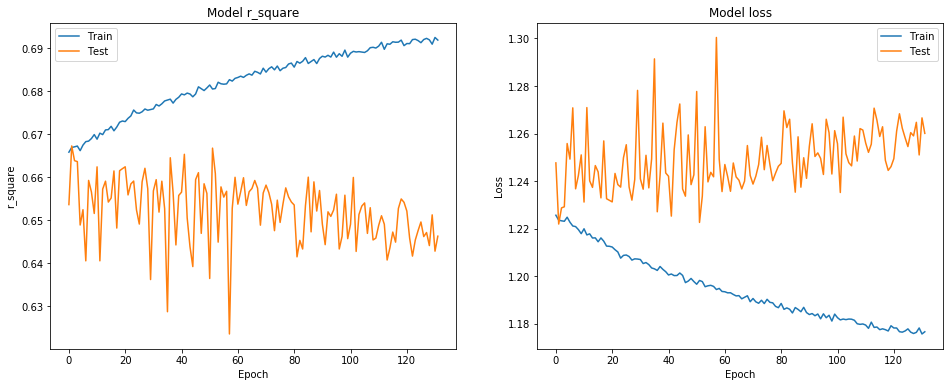

In [29]:
plot_history(fdcnn_rnn_history, 'r_square')
plt.show();